# Lab 3 - Cross Validation for KNN ( Moses Mbabaali 4846019)

So far you experienced how the use of different possible values of K may influence the results, also depending on the type of data, their cardinality, and the amount of noise.

#### We now apply Cross Validation for the choice of an appropriate value for the parameter K.

### Cross Validation

We first put in the code functions that you should recognize at this points

In [313]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
#from matplotlib.mlab import griddata
import pickle

In [314]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [315]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D
    

In [316]:
def kNNClassify(Xtr, Ytr, k, Xte, Te=1):

    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        if(Te==1): # test set
            neigh_indexes = np.argsort(dist[idx, :])[:k]
        else:
            neigh_indexes = np.argsort(dist[idx, :])[1:k+1]
            
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)

    return Ypred

In [317]:
def linearBinaryClass(n, low_D, high_D, m, q):

    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    
    return X,Y

In [318]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [319]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred!=Ytrue))/len(Ytrue)

### Compute the test error for different values of K

Having access to both the training and the test, we may start by having a look at the trend of the test error as the value of K increases. To this purpose we use the function

##### train_err, test_err = trainTestAnalysis(Ks, Xtr, Ytr, Xte, Yte)
where
- <b>Ks</b>: array of possible values for K to be considered
- <b>Xtr</b> and <b>Ytr</b>: respectively, input and output of the training set
- <b>Xts</b> and <b>Yts</b>: respectively, input and output of the test set
- <b>train_err</b>, <b>test_err</b>: array of errors on training and test for different values of K

In [320]:
def trainTestAnalysis(Ks, Xtr, Ytr, Xte, Yte):

    train_err = np.zeros(np.shape(Ks))
    test_err = np.zeros(np.shape(Ks))

    kpos = 0
    for kpos in range(len(Ks)):
        Ypredte = kNNClassify(Xtr, Ytr, Ks[kpos], Xte)
        test_err[kpos] = calcError(Ypredte, Yte)
        
        Ypredtr = kNNClassify(Xtr, Ytr, Ks[kpos], Xtr)
        train_err[kpos] = calcError(Ypredtr, Ytr)

    return train_err, test_err

### hold-out Cross Validation

For KNN, we use the following function

##### best_k, Vm, Vs, Tm, Ts = holdoutCVkNN(Xtr, Ytr, perc, n_rep, k_list)
where
- <b>Xtr</b> and <b>Ytr</b> are respectively, input and output of the training set
- <b>perc</b>: percentage of training set data ot be used for validation
- <b>n_rep</b>: number of repetitions (samplings) of validation set for each value of the parameter
- <b>k_list</b>:  array of possible values for K to be considered
- <b>best_k</b>: the value in k_list that minimizes the mean of the validation error
- <b>Vm</b> and <b>Vs</b>: mean and variance of the validation error for each value of the parameter
- <b>Tm</b> and <b>Ts</b>: mean and variance of the training error for each value of the parameter

In [321]:
def holdoutCVkNN(Xtr, Ytr, perc, n_rep, k_list):

    if perc < 1 or perc > 100:
        print("perc should be a percentage value between 0 and 100.")
        return -1

    if n_rep <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = k_list.size

    n_tot = Xtr.shape[0]
    n_train = int(np.ceil(n_tot * (1 - float(perc) / 100)))

    Tm = np.zeros(num_k)
    Ts = np.zeros(num_k)
    Vm = np.zeros(num_k)
    Vs = np.zeros(num_k)

    for kdx, k in enumerate(k_list):
        for rip in range(n_rep):
            # Randombly select a subset of the training set
            rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)

            X = Xtr[rand_idx[:n_train]]
            Y = Ytr[rand_idx[:n_train]]
            X_val = Xtr[rand_idx[n_train:]]
            Y_val = Ytr[rand_idx[n_train:]]

            # Compute the training error of the kNN classifier for the given value of k
            trError = calcError(kNNClassify(X, Y, k, X), Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error of the kNN classifier for the given value of k
            valError = calcError(kNNClassify(X, Y, k, X_val), Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2

    Tm = Tm / n_rep
    Ts = Ts / n_rep - Tm ** 2

    Vm = Vm / n_rep
    Vs = Vs / n_rep - Vm ** 2

    best_k_idx = np.argmin(Vm)
    best_k = k_list[best_k_idx]

    return best_k, Vm, Vs, Tm, Ts

### K-Fold Cross Validation

For KNN, we use the following function


##### best_k, Vm, Vs, Tm, Ts = KFoldCVkNN(Xtr, Ytr, KF, k_list)
where
- <b>Xtr</b> and <b>Ytr</b> are respectively, input and output of the training set
- <b>KF</b>: number of folds
- <b>k_list</b>:  array of possible values for K to be considered
- <b>best_k</b>: the value in k_list that minimizes the mean of the validation error
- <b>Vm</b> and <b>Vs</b>: mean and variance of the validation error for each value of the parameter
- <b>Tm</b> and <b>Ts</b>: mean and variance of the training error for each value of the parameter

In [322]:
def KFoldCVkNN(Xtr, Ytr, KF, k_list,n_rep):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = k_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_k)
    Ts = np.zeros(num_k)
    Vm = np.zeros(num_k)
    Vs = np.zeros(num_k)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, k in enumerate(k_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[flags==0]
            Y = Ytr[flags==0]
            X_val = Xtr[flags==1]
            Y_val = Ytr[flags==1]

            # Compute the training error of the kNN classifier for the given value of k
            trError = calcError(kNNClassify(X, Y, k, X), Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error of the kNN classifier for the given value of k
            valError = calcError(kNNClassify(X, Y, k, X_val), Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / n_rep
    Ts = Ts / n_rep - Tm ** 2

    Vm = Vm / n_rep
    Vs = Vs / n_rep - Vm ** 2

    best_k_idx = np.argmin(Vm)
    k = k_list[best_k_idx]

    return k, Vm, Vs, Tm, Ts

### Trying model selection with different strategies

It is now time to try and compare different strategies for selecting the best value for the parameter K. To this purpose we provide you some example datasets for binary classification problems (see Material.zip) you can play with. 

The datasets have the following properties:
- (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
- (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
- (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
- (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

To load a dataset (e.g. Training1/Test1) use the following:    

In [323]:
with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/Training1.dat","rb") as f:
    [Xtr, Ytr] = pickle.load(f)
with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/Test1.dat","rb") as f:
    [Xte, Yte] = pickle.load(f) 

### Assignment

For each dataset, try and reason on the expected behavior: considering amount of data and noise, what do you expect to be a reasonable value for K? 

The, perform the following and compare the results:
- Have a look at the trend of the test error as K increases (function trainTestAnalysis), plot the error and derive the value of K for which it reaches the minimum
- Do the same using hold-out Cross Validation
- Do the same using K-Fold Cross Validation

Take a look ad the K's that you obtained in the different cases...


# Question one trainTestAnalysis.

In [324]:
def bestk(Training, Test, Maxk):
    """ Takes in three arguments the 
    Training: Training set as a string and
    Test: Testing set as a string
    Maxk: The maximum k as an interger """
    
    with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/{}.dat".format(Training),"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/{}.dat".format(Test),"rb") as f:
        [Xte, Yte] = pickle.load(f)
    
    xi = list(range(1,Maxk+1,1))
    train_err,test_err =trainTestAnalysis ([i for i in range(1,Maxk+1,1)], Xtr, Ytr, Xte, Yte)
    
    a = []
    for i,j in np.nditer([train_err, test_err]):
        a.append(i+j)
    
    plt.plot(xi,train_err,  label = 'Train_Error')
    plt.plot(xi,test_err, label = 'Test_Error')
    plt.title('Train and Test Error Vs K')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.grid(b=True)
    plt.legend()
    
    print("- The best K for the dataset {} is K={} and its value is {}".format(Training,train_err.argmin()+1,train_err.min()))
    print("- The best K for the dataset {} is K={} and its value is {}".format(Test,test_err.argmin()+1,test_err.min()))
    print("- Since the Error rate of the training set is low at the begining but as you increase the data it also increases the best K is the one for Testset.")

- The best K for the dataset Training1 is K=1 and its value is 0.0
- The best K for the dataset Test1 is K=9 and its value is 0.0
- Since the Error rate of the training set is low at the begining but as you increase the data it also increases the best K is the one for Testset.


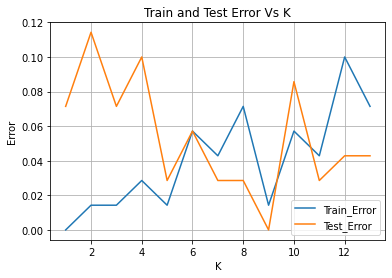

In [325]:
bestk("Training1","Test1", 13)

- The best K for the dataset Training2 is K=1 and its value is 0.0
- The best K for the dataset Test2 is K=15 and its value is 0.025
- Since the Error rate of the training set is low at the begining but as you increase the data it also increases the best K is the one for Testset.


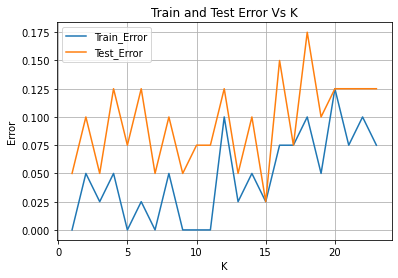

In [326]:
bestk("Training2","Test2", 23)

- The best K for the dataset Training3 is K=1 and its value is 0.0
- The best K for the dataset Test3 is K=11 and its value is 0.2
- Since the Error rate of the training set is low at the begining but as you increase the data it also increases the best K is the one for Testset.


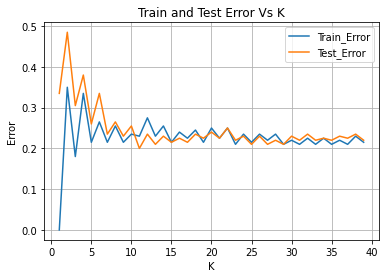

In [327]:
bestk("Training3","Test3", 39)

- The best K for the dataset Training4 is K=1 and its value is 0.0
- The best K for the dataset Test4 is K=5 and its value is 0.065
- Since the Error rate of the training set is low at the begining but as you increase the data it also increases the best K is the one for Testset.


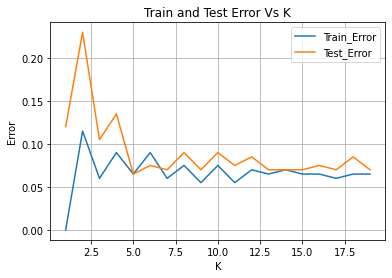

In [328]:
bestk("Training4","Test4", 19)

# Question 2 hold-out Cross Validation.

In [331]:
def holdoutCv(perc,Training, no_rep, maxk):
    """ Takes in four arguments perc: Percentage of Validation as an int between 0 to 100
                 Training: Training dataset as a string 
                 no_rep: number of repitions as an int 
                 maxk: The maximum number of k as an int """
    
    with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/{}.dat".format(Training),"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    best_k, Vm, Vs, Tm, Ts = holdoutCVkNN(Xtr, Ytr, perc, no_rep, [i for i in range(1,maxk+1,1)])
    
    xi = list(range(1,maxk+1,1))
    
    plt.plot(xi,Vm,  label = 'Validation Error Mean')
    plt.plot(xi,Vs, label = 'Validation Error Variance')
    plt.plot(xi,Tm, label = 'Training error Mean')
    plt.plot(xi,Ts, label = 'Training error Variance')
    plt.title('Error Vs K')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.grid(b=True)
    plt.legend()
    print("- The best K for {} is K={}".format(Training, best_k))

- The best K for Training1 is K=3


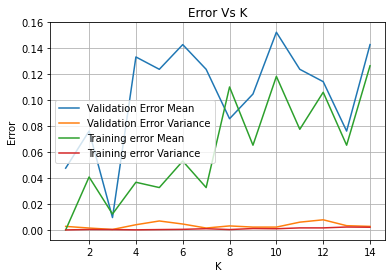

In [332]:
holdoutCv(30,"Training1",5,14)

- The best K for Training2 is K=1


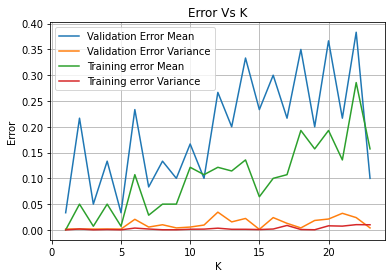

In [333]:
holdoutCv(30,"Training2",5,23)

- The best K for Training3 is K=25


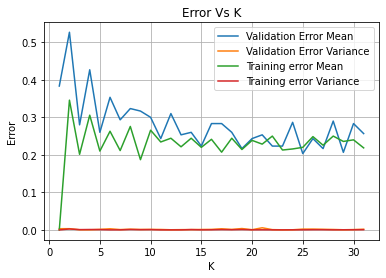

In [334]:
holdoutCv(30,"Training3",5,31)

- The best K for Training4 is K=9


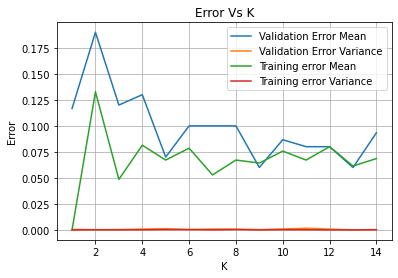

In [335]:
holdoutCv(30,"Training4",5,14)

# Question 3 KFoldCVkNN

In [336]:
def KfoldCV(KF,n_rep,maxk,Training):
    """ This function takes in 3 arguments KF: Which is the KFold as an int,
                                           n_prep: Number of repitions as an int 
                                           maxk: The maximum number of k as an int
                                           Training: The training set as a string 
                                           """
    
    with open("/home/mb/Documents/MachineLearningAssingments/Material/Material/{}.dat".format(Training),"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    
    k, Vm, Vs, Tm, Ts = KFoldCVkNN(Xtr, Ytr, KF, [i for i in range(1,maxk+1,1)],n_rep)
    xi = list(range(1,maxk+1,1))
    
    plt.plot(xi,Vm,  label = 'Validation Error Mean')
    plt.plot(xi,Vs, label = 'Validation Error Variance')
    plt.plot(xi,Tm, label = 'Training error Mean')
    plt.plot(xi,Ts, label = 'Training error Variance')
    plt.title('Error Vs K')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.grid(b=True)
    plt.legend()
    print("- The best K for {} is K={}".format(Training, k))

- The best K for Training1 is K=3


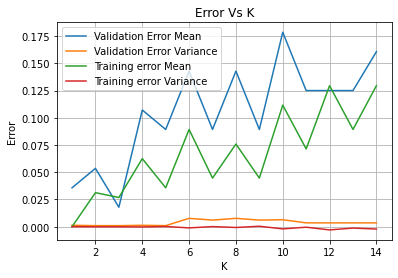

In [337]:
KfoldCV(5,4,14,"Training1")

- The best K for Training2 is K=3


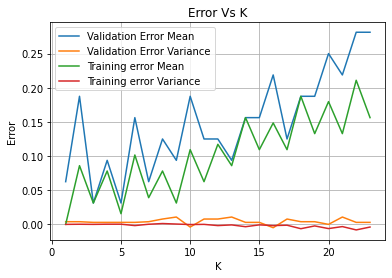

In [338]:
KfoldCV(5,4,23,"Training2")

- The best K for Training3 is K=27


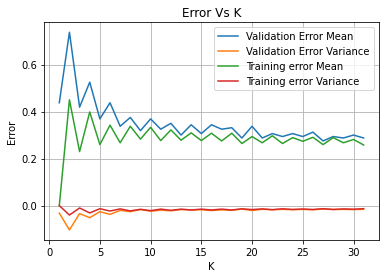

In [339]:
KfoldCV(5,4,31,"Training3")

- The best K for Training4 is K=7


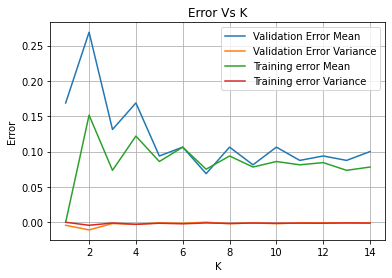

In [340]:
KfoldCV(5,4,14,"Training4")